# Quantum adder using QFT algorithm

The QFT algorithm can be used to add numbers together by performing a QFT on a qubit string which represents your first number, and then adding the phases of the second number, then finally performing the inverse QFT to get your result. For this example, we shall be focusing on the addition of $5+3$.

In [1]:
"""Imports"""
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector

sim_backend = AerSimulator()

One thing to note before starting is that qiskit treats qubit strings just as with bit strings with $q_{n}...q_{0}$. This is the reverse of how it is normally done by Physicists so that's always important to keep in mind!

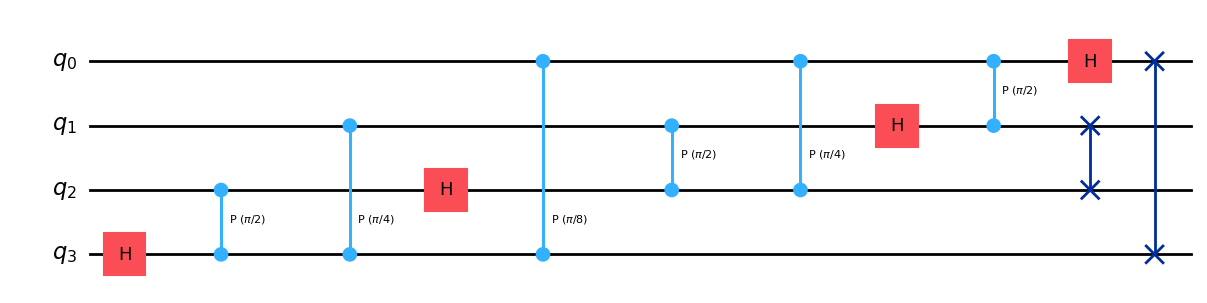

In [2]:
"""Creating the qft circuit"""
qft_circ = QuantumCircuit(4)

# Apply gates to the MSB (Most Significant Bit) q_{3}
qft_circ.h(3)
qft_circ.cp(2 * np.pi / 4, 2, 3)
qft_circ.cp(2 * np.pi / 8, 1, 3)
qft_circ.cp(2 * np.pi / 16, 0, 3)

# Apply gates to q_{2} 
qft_circ.h(2)
qft_circ.cp(2 * np.pi / 4, 1, 2)
qft_circ.cp(2 * np.pi / 8, 0, 2)

# Apply gates to q_{1}
qft_circ.h(1)
qft_circ.cp(2 * np.pi / 4, 0, 1)

# Apply gates to q_{0}
qft_circ.h(0)
qft_circ.swap(3,0)
qft_circ.swap(2,1)

qft_circ.draw('mpl')


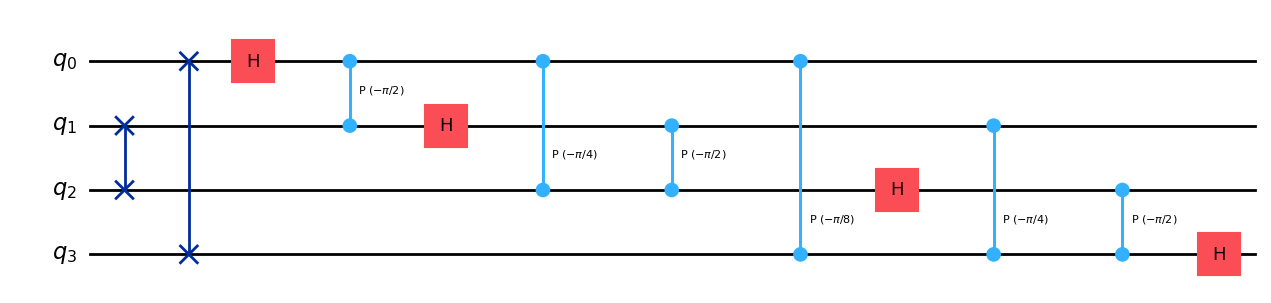

In [3]:
"""Generating the inverse of this circuit"""
qft_inv = qft_circ.inverse()
qft_inv.draw('mpl')

Now, before we continue, let's work through the maths. Since, in a previous problem we already calculated $U_{QFT}\ket{101}$ i.e., the QFT of 5, we already have most of the phases:
$$
U_{QFT}\ket{101} = \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right)
\otimes \left( \frac{\ket{0} + i\ket{1}}{\sqrt{2}}\right)
\otimes \left( \frac{\ket{0} + e^{i \frac{5\pi}{4}}\ket{1}}{\sqrt{2}}\right).
$$
All we have to do to express this with 4 qubits is add on the tensor product
$$
U_{QFT}\ket{0101} = U_{QFT}\ket{101}\otimes \left( \frac{\ket{0} + e^{i \frac{5\pi}{8}}\ket{1}}{\sqrt{2}}\right).
$$

Thus, we can set initialize our quantum circuit to be in the $\ket{0011}=3$ state and then add the phases of $U_{QFT}\ket{0101}$ via $P$ gates where
$$
P(\theta) = \begin{pmatrix}
1 & 0 \\
0 & e^{i \theta}
\end{pmatrix}.
$$

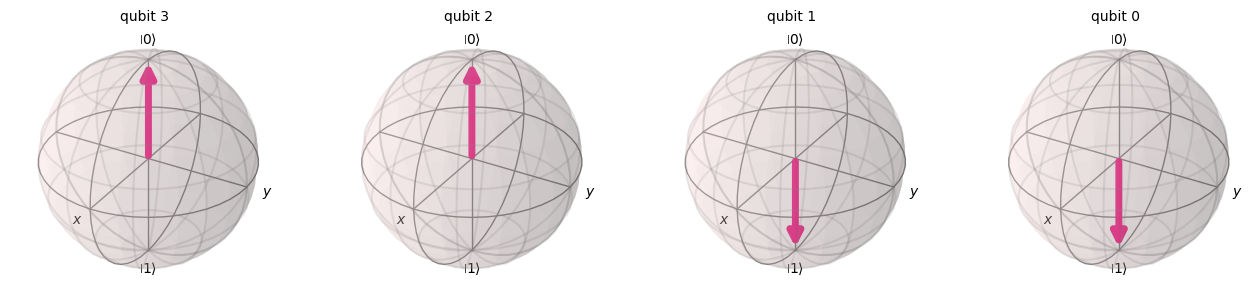

In [4]:
"""Creating our Quantum adder"""
qc = QuantumCircuit(4)
# Initialize the state to represent the number 3
qc.x(0)
qc.x(1)

plot_bloch_multivector(qc,reverse_bits=True)

As you can see, the state starts off as $\ket{0011}$.

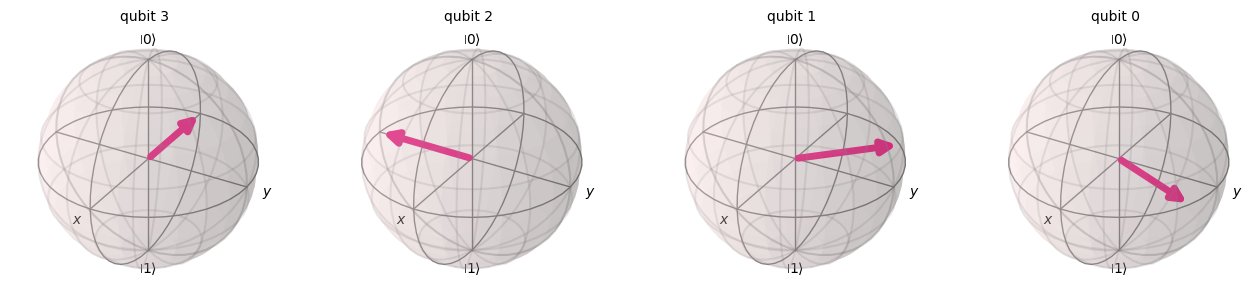

In [5]:
qc.append(qft_circ, qc.qubits) # Apply the QFT circuit

plot_bloch_multivector(qc, reverse_bits=True)

And after the QFT, you can see that the state is in the uniform superposition
$$
U_{QFT}\ket{0011} = \underbrace{\left( \frac{\ket{0} - \ket{1}}{\sqrt{2}}\right)}_{q_{3}}
\otimes \underbrace{\left( \frac{\ket{0} - i\ket{1}}{\sqrt{2}}\right)}_{q_{2}}
\otimes \underbrace{\left( \frac{\ket{0} + e^{i \frac{3\pi}{4}}\ket{1}}{\sqrt{2}}\right)}_{q_{1}}
\otimes \underbrace{\left( \frac{\ket{0} + e^{i \frac{3\pi}{8}}\ket{1}}{\sqrt{2}}\right)}_{q_{0}}
$$
To show that this superposition is uniform, we can simulate measurement of this system and plot the frequencies.

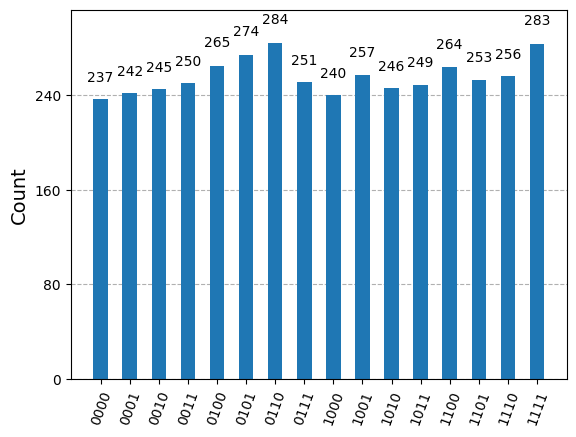

In [6]:
shots = 4096
qc_test = qc.copy()
qc_test.measure_all()

transpiled_qc = transpile(qc_test,backend=sim_backend, optimization_level=3)
job = sim_backend.run(transpiled_qc,shots=shots)
counts = job.result().get_counts()
plot_histogram(counts)

Now that we know that we have a QFT representing the number 3, we now need to apply the phase rotations which correspond to the QFT of 5.

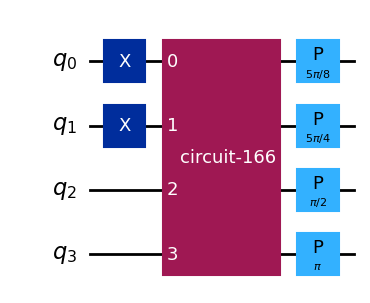

In [7]:
"""Adding stage (phase application)"""

#Remember, the qubits are flipped
qc.p(np.pi, 3) # q_{3} phase
qc.p(np.pi / 2,2) # q_{2} phase
qc.p(5 * np.pi / 4, 1) # q_{1} phase
qc.p(5 * np.pi / 8, 0) # q_{0} phase
qc.draw('mpl')

We are ready now to add our inverse QFT and see what state our system is in.

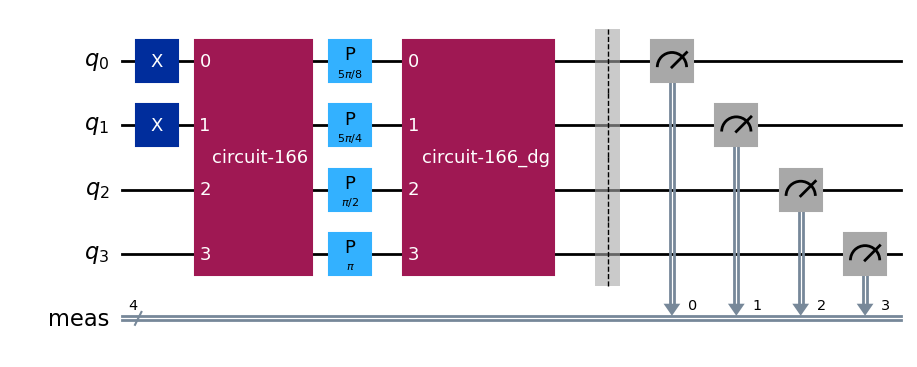

In [8]:
qc.append(qft_inv, qc.qubits) # Apply the inverse QFT
qc.measure_all()
qc.draw('mpl')

This is very concise, but let's see the full circuit in action!

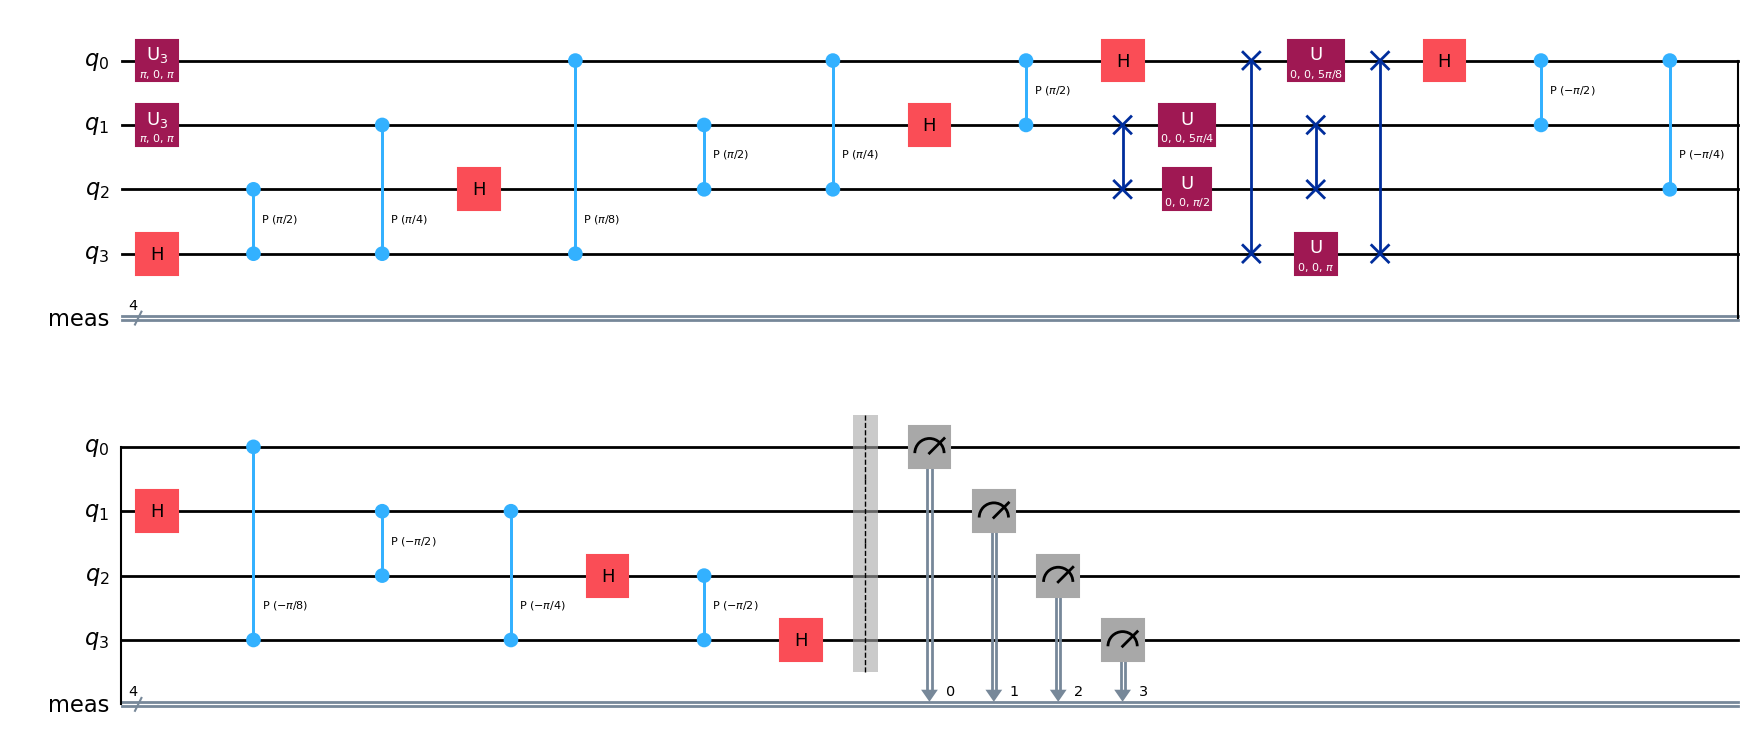

In [9]:
qc.decompose().draw('mpl')

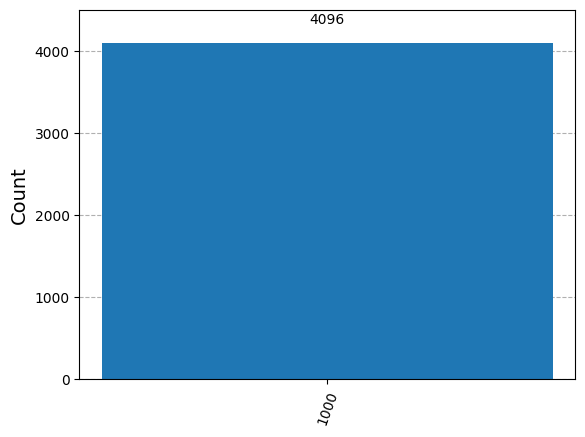

In [10]:
"""Simulating repeated measurement"""
shots = 4096
transpiled_qc = transpile(qc,backend=sim_backend, optimization_level=3)
job = sim_backend.run(transpiled_qc,shots=shots)
counts = job.result().get_counts()
plot_histogram(counts)

And with that, our final measurement always results in the state $\ket{1000}$ which is binary for the number 8. Ergo, we have created a highly inefficient adder using the QFT algorithm and phase shift gates!!!

# A more efficient alternative

One of the main goals of computing is to create building blocks which you can use to make more and more complicated systems. One of the most fundamental circuits in classical computing is the full adder, and is often one of the first logical systems you are expected to make in any computer science class. A quantum full adder exists and does not consist of the method outlined above, but utilizes troffoli and cnot gates to perform much more efficient and scalable arithmetic that doesn't require you to know the phases beforehand. An article describing how to implement a quantum full adder in a quantum assembly language can be found [here](https://www.quantum-inspire.com/kbase/full-adder/).

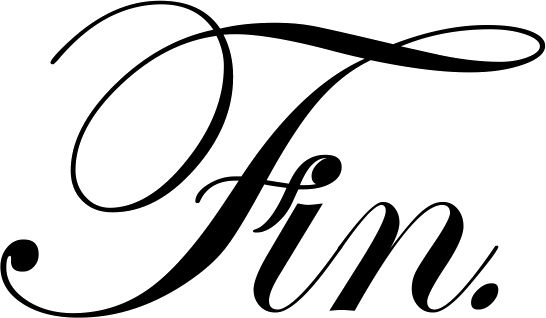